In [155]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math, time
import datetime
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
# fixar random seed para se puder reproduzir os resultados
seed = 9
np.random.seed(seed)

In [156]:
def read_csv_dataset(file_name):
    df = pd.read_csv(file_name)
    print('Formato do dataset: ',df.shape)
    print('Feature Engineering...')
    date_split = df['Month'].str.split('-').str
    df['Year'], df['Month'] = date_split
    m = {'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12, }
    df['Month'] = df['Month'].map(m)
    df.drop(df.columns[[3,4,5,6]], axis=1, inplace=True) #vou só ficar com as colunas 0,1,2,6
    df.drop(df.tail(2).index,inplace=True) #eliminar as duas últimas linhas com lixo
    df.dropna() #just to be sure
    df["Year"] = df["Year"].astype(dtype=np.float64) #converter coluna do ano para floats
    print('Formato do dataset: ',df.shape)
    return df

In [157]:
#função load_data do lstm.py configurada para aceitar qualquer número de parametros
#o último atributo é que fica como label (resultado)
#stock é um dataframe do pandas (uma especie de dicionario + matriz)
#seq_len é o tamanho da janela a ser utilizada na serie temporal
def load_data(df_dados, janela):
    #print(df_dados)
    qt_atributos = len(df_dados.columns)
    mat_dados = df_dados.as_matrix() #converter dataframe para matriz (lista com lista de cada registo)
    tam_sequencia = janela + 1
    res = []
    for i in range(len(mat_dados) - tam_sequencia): #numero de registos - tamanho da sequencia
         res.append(mat_dados[i: i + tam_sequencia])
    res = np.array(res) #dá como resultado um np com uma lista de matrizes (janela deslizante ao longo da serie)
    print(res.shape)

    #escolher apenas os dados referentes ao primeiro e segundo ano para treinar a rede e do terceiro para testar

    qt_casos_treino = 0
    for i in range(len(res)):
        fortrain = 0
        for j in range(len(res[i])):
            if (res[i][j][3] < 3):
                fortrain = 1
        qt_casos_treino += fortrain 
    
    #qt_casos_treino = int(round(0.9 * res.shape[0])) #90% passam a ser casos de treino
    
    train = res[:qt_casos_treino, :]
    x_train = train[:, :-1] #menos um registo pois o ultimo registo é o registo a seguir à janela
    y_train = train[:, -1][:,2] #para ir buscar o atributo referente às sales para a lista dos labels
    x_test = res[qt_casos_treino:, :-1]
    y_test = res[qt_casos_treino:, -1][:,2]
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], qt_atributos))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], qt_atributos))
   # print("TRAIN",train)
   # print("X_TRAIN",x_train)
   # print("Y_TRAIN",y_train)
   # print("X_TEST",x_test)
   # print("Y_TEST",y_test)
    return [x_train, y_train, x_test, y_test]

In [163]:
# Etapa 2 - Definir a topologia da rede (arquitectura do modelo) e compilar '''
def build_model2(janela):
    model = Sequential()
    model.add(LSTM(256, input_shape=(janela, 4), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(128, input_shape=(janela, 4), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64, input_shape=(janela, 4), return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation="relu", kernel_initializer="uniform"))
    model.add(Dense(1, activation="linear", kernel_initializer="uniform"))
    model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
    return model

In [164]:
def print_model(model,fich):
 from keras.utils import plot_model
 plot_model(model, to_file=fich, show_shapes=True, show_layer_names=True)

In [165]:
#imprime um grafico com os valores de teste e com as correspondentes tabela de previsões
def print_series_prediction(y_test,predic):
    diff=[]
    racio=[]
    for i in range(len(y_test)): #para imprimir tabela de previsoes
        racio.append( (y_test[i]/predic[i])-1)
        diff.append( abs(y_test[i]- predic[i]))
        print('valor: %f ---> Previsão: %f Diff: %f Racio: %f' % (y_test[i],predic[i], diff[i],racio[i]))
    plt.plot(y_test,color='blue', label='y_test')
    plt.plot(predic,color='red', label='prediction') #este deu uma linha em branco
    plt.plot(diff,color='green', label='diff')
    plt.plot(racio,color='yellow', label='racio')
    plt.legend(loc='upper left')
    plt.show()

In [166]:
def LSTM_():
    df = read_csv_dataset("advertising-and-sales-data-36-co.csv")
    print("df", df.shape)
    print(df.head())
    janela = 3 #tamanho da Janela deslizante
    #X_train, y_train, X_test, y_test = load_data(df[::-1], janela)# o df[::-1] é o df por ordem inversa
    X_train, y_train, X_test, y_test = load_data(df, janela)# o ler o def por ordem normal
    print("X_train", X_train.shape)
    print("y_train", y_train.shape)
    print("X_test", X_test.shape)
    print("y_test", y_test.shape)
    model = build_model2(janela)
    model.fit(X_train, y_train, batch_size=512, epochs=500, validation_split=0.1, verbose=1)
    #print_model(model,"lstm_model.png")
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))
    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    print(model.metrics_names)
    p = model.predict(X_test)
    predic = np.squeeze(np.asarray(p)) #para transformar uma matriz de uma coluna e n linhas em um np array de n elementos
    print_series_prediction(y_test,predic)
    # MSE- (Mean square error), RMSE- (root mean square error) - 
    # o significado de RMSE depende do range da label. para o mesmo range menor é melhor.

Formato do dataset:  (38, 7)
Feature Engineering...
Formato do dataset:  (36, 4)
df (36, 4)
   Month  Advertising  Sales  Year
0    1.0         12.0   15.0   1.0
1    2.0         20.5   16.0   1.0
2    3.0         21.0   18.0   1.0
3    4.0         15.5   27.0   1.0
4    5.0         15.3   21.0   1.0
(32, 4, 4)
X_train (24, 3, 4)
y_train (24,)
X_test (8, 3, 4)
y_test (8,)


C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Train on 21 samples, validate on 3 samples
Epoch 1/500
21/21 [==============================] - 5s 216ms/step - loss: 1320.6482 - acc: 0.0000e+00 - val_loss: 505.5221 - val_acc: 0.0000e+00
Epoch 2/500
21/21 [==============================] - 0s 2ms/step - loss: 1320.3590 - acc: 0.0000e+00 - val_loss: 505.3962 - val_acc: 0.0000e+00
Epoch 3/500
21/21 [==============================] - 0s 2ms/step - loss: 1320.0638 - acc: 0.0000e+00 - val_loss: 505.2346 - val_acc: 0.0000e+00
Epoch 4/500
21/21 [==============================] - 0s 2ms/step - loss: 1319.7445 - acc: 0.0000e+00 - val_loss: 505.0278 - val_acc: 0.0000e+00
Epoch 5/500
21/21 [==============================] - 0s 2ms/step - loss: 1319.2740 - acc: 0.0000e+00 - val_loss: 504.7646 - val_acc: 0.0000e+00
Epoch 6/500
21/21 [==============================] - 0s 2ms/step - loss: 1318.7390 - acc: 0.0000e+00 - val_loss: 504.4273 - val_acc: 0.0000e+00
Epoch 7/500
21/21 [==============================] - 0s 2ms/step - loss: 1318.0321 - acc: 0

Epoch 58/500
21/21 [==============================] - 0s 2ms/step - loss: 1084.7142 - acc: 0.0000e+00 - val_loss: 373.2539 - val_acc: 0.0000e+00
Epoch 59/500
21/21 [==============================] - 0s 2ms/step - loss: 1080.3741 - acc: 0.0000e+00 - val_loss: 369.1078 - val_acc: 0.0000e+00
Epoch 60/500
21/21 [==============================] - 0s 2ms/step - loss: 1074.8149 - acc: 0.0000e+00 - val_loss: 364.9310 - val_acc: 0.0000e+00
Epoch 61/500
21/21 [==============================] - 0s 2ms/step - loss: 1062.7723 - acc: 0.0000e+00 - val_loss: 360.7207 - val_acc: 0.3333
Epoch 62/500
21/21 [==============================] - 0s 2ms/step - loss: 1059.8118 - acc: 0.0000e+00 - val_loss: 356.4851 - val_acc: 0.3333
Epoch 63/500
21/21 [==============================] - 0s 2ms/step - loss: 1047.8099 - acc: 0.0000e+00 - val_loss: 352.2233 - val_acc: 0.3333
Epoch 64/500
21/21 [==============================] - 0s 2ms/step - loss: 1039.6534 - acc: 0.0000e+00 - val_loss: 347.9381 - val_acc: 0.3333
E

Epoch 116/500
21/21 [==============================] - 0s 2ms/step - loss: 538.3760 - acc: 0.0000e+00 - val_loss: 173.4454 - val_acc: 0.0000e+00
Epoch 117/500
21/21 [==============================] - 0s 2ms/step - loss: 545.0278 - acc: 0.0000e+00 - val_loss: 172.5049 - val_acc: 0.0000e+00
Epoch 118/500
21/21 [==============================] - 0s 2ms/step - loss: 556.9446 - acc: 0.0000e+00 - val_loss: 171.6957 - val_acc: 0.0000e+00
Epoch 119/500
21/21 [==============================] - 0s 2ms/step - loss: 519.6863 - acc: 0.0000e+00 - val_loss: 171.0147 - val_acc: 0.0000e+00
Epoch 120/500
21/21 [==============================] - 0s 2ms/step - loss: 525.8926 - acc: 0.0000e+00 - val_loss: 170.4645 - val_acc: 0.0000e+00
Epoch 121/500
21/21 [==============================] - 0s 2ms/step - loss: 501.7916 - acc: 0.0000e+00 - val_loss: 170.0436 - val_acc: 0.0000e+00
Epoch 122/500
21/21 [==============================] - 0s 2ms/step - loss: 512.6947 - acc: 0.0000e+00 - val_loss: 169.7531 - val_a

Epoch 174/500
21/21 [==============================] - 0s 2ms/step - loss: 323.2481 - acc: 0.0476 - val_loss: 277.7654 - val_acc: 0.0000e+00
Epoch 175/500
21/21 [==============================] - 0s 2ms/step - loss: 319.1754 - acc: 0.0000e+00 - val_loss: 280.5310 - val_acc: 0.0000e+00
Epoch 176/500
21/21 [==============================] - 0s 2ms/step - loss: 313.8761 - acc: 0.0000e+00 - val_loss: 283.2595 - val_acc: 0.0000e+00
Epoch 177/500
21/21 [==============================] - 0s 2ms/step - loss: 309.5911 - acc: 0.0476 - val_loss: 285.8995 - val_acc: 0.0000e+00
Epoch 178/500
21/21 [==============================] - 0s 2ms/step - loss: 328.1057 - acc: 0.0000e+00 - val_loss: 288.4695 - val_acc: 0.0000e+00
Epoch 179/500
21/21 [==============================] - 0s 2ms/step - loss: 317.4827 - acc: 0.0000e+00 - val_loss: 290.9149 - val_acc: 0.0000e+00
Epoch 180/500
21/21 [==============================] - 0s 2ms/step - loss: 325.6182 - acc: 0.0000e+00 - val_loss: 293.3072 - val_acc: 0.00

Epoch 231/500
21/21 [==============================] - 0s 2ms/step - loss: 289.5681 - acc: 0.0476 - val_loss: 348.8398 - val_acc: 0.0000e+00
Epoch 232/500
21/21 [==============================] - 0s 2ms/step - loss: 301.0484 - acc: 0.0952 - val_loss: 349.0258 - val_acc: 0.0000e+00
Epoch 233/500
21/21 [==============================] - 0s 2ms/step - loss: 295.5260 - acc: 0.0476 - val_loss: 349.2191 - val_acc: 0.0000e+00
Epoch 234/500
21/21 [==============================] - 0s 2ms/step - loss: 279.1755 - acc: 0.0476 - val_loss: 349.4792 - val_acc: 0.0000e+00
Epoch 235/500
21/21 [==============================] - 0s 2ms/step - loss: 302.4363 - acc: 0.0000e+00 - val_loss: 349.7598 - val_acc: 0.0000e+00
Epoch 236/500
21/21 [==============================] - 0s 2ms/step - loss: 305.5209 - acc: 0.0476 - val_loss: 349.9749 - val_acc: 0.0000e+00
Epoch 237/500
21/21 [==============================] - 0s 2ms/step - loss: 323.6291 - acc: 0.0476 - val_loss: 350.1384 - val_acc: 0.0000e+00
Epoch 238

Epoch 289/500
21/21 [==============================] - 0s 2ms/step - loss: 329.1768 - acc: 0.0000e+00 - val_loss: 351.7878 - val_acc: 0.0000e+00
Epoch 290/500
21/21 [==============================] - 0s 2ms/step - loss: 312.6944 - acc: 0.0000e+00 - val_loss: 351.7610 - val_acc: 0.0000e+00
Epoch 291/500
21/21 [==============================] - 0s 2ms/step - loss: 300.3050 - acc: 0.0000e+00 - val_loss: 351.7478 - val_acc: 0.0000e+00
Epoch 292/500
21/21 [==============================] - 0s 2ms/step - loss: 305.5659 - acc: 0.0476 - val_loss: 351.7081 - val_acc: 0.0000e+00
Epoch 293/500
21/21 [==============================] - 0s 2ms/step - loss: 304.6234 - acc: 0.0000e+00 - val_loss: 351.5867 - val_acc: 0.0000e+00
Epoch 294/500
21/21 [==============================] - 0s 2ms/step - loss: 328.3099 - acc: 0.0476 - val_loss: 351.3912 - val_acc: 0.0000e+00
Epoch 295/500
21/21 [==============================] - 0s 2ms/step - loss: 271.4427 - acc: 0.0476 - val_loss: 351.3683 - val_acc: 0.0000e+

Epoch 346/500
21/21 [==============================] - 0s 2ms/step - loss: 298.0005 - acc: 0.0000e+00 - val_loss: 350.3368 - val_acc: 0.0000e+00
Epoch 347/500
21/21 [==============================] - 0s 2ms/step - loss: 331.3475 - acc: 0.0000e+00 - val_loss: 349.9896 - val_acc: 0.0000e+00
Epoch 348/500
21/21 [==============================] - 0s 2ms/step - loss: 303.9186 - acc: 0.0000e+00 - val_loss: 349.7144 - val_acc: 0.0000e+00
Epoch 349/500
21/21 [==============================] - 0s 2ms/step - loss: 328.8676 - acc: 0.0000e+00 - val_loss: 349.4095 - val_acc: 0.0000e+00
Epoch 350/500
21/21 [==============================] - 0s 2ms/step - loss: 305.9662 - acc: 0.0476 - val_loss: 349.1781 - val_acc: 0.0000e+00
Epoch 351/500
21/21 [==============================] - 0s 2ms/step - loss: 324.0689 - acc: 0.0476 - val_loss: 348.8705 - val_acc: 0.0000e+00
Epoch 352/500
21/21 [==============================] - 0s 2ms/step - loss: 294.8986 - acc: 0.0000e+00 - val_loss: 348.6625 - val_acc: 0.00

Epoch 403/500
21/21 [==============================] - 0s 2ms/step - loss: 302.9280 - acc: 0.0000e+00 - val_loss: 352.0488 - val_acc: 0.0000e+00
Epoch 404/500
21/21 [==============================] - 0s 2ms/step - loss: 301.3987 - acc: 0.0000e+00 - val_loss: 352.0156 - val_acc: 0.0000e+00
Epoch 405/500
21/21 [==============================] - 0s 2ms/step - loss: 308.6067 - acc: 0.0000e+00 - val_loss: 351.9702 - val_acc: 0.0000e+00
Epoch 406/500
21/21 [==============================] - 0s 2ms/step - loss: 320.0605 - acc: 0.0476 - val_loss: 351.8830 - val_acc: 0.0000e+00
Epoch 407/500
21/21 [==============================] - 0s 2ms/step - loss: 302.9664 - acc: 0.0000e+00 - val_loss: 351.7603 - val_acc: 0.0000e+00
Epoch 408/500
21/21 [==============================] - 0s 2ms/step - loss: 288.0062 - acc: 0.0952 - val_loss: 351.7840 - val_acc: 0.0000e+00
Epoch 409/500
21/21 [==============================] - 0s 2ms/step - loss: 281.3710 - acc: 0.0000e+00 - val_loss: 351.8462 - val_acc: 0.00

Epoch 460/500
21/21 [==============================] - 0s 2ms/step - loss: 312.2913 - acc: 0.0000e+00 - val_loss: 351.7634 - val_acc: 0.0000e+00
Epoch 461/500
21/21 [==============================] - 0s 2ms/step - loss: 304.8087 - acc: 0.0000e+00 - val_loss: 351.8260 - val_acc: 0.0000e+00
Epoch 462/500
21/21 [==============================] - 0s 2ms/step - loss: 314.2109 - acc: 0.0476 - val_loss: 351.8159 - val_acc: 0.0000e+00
Epoch 463/500
21/21 [==============================] - 0s 2ms/step - loss: 293.2809 - acc: 0.0000e+00 - val_loss: 351.8684 - val_acc: 0.0000e+00
Epoch 464/500
21/21 [==============================] - 0s 2ms/step - loss: 313.7341 - acc: 0.0000e+00 - val_loss: 351.7929 - val_acc: 0.0000e+00
Epoch 465/500
21/21 [==============================] - 0s 2ms/step - loss: 332.5804 - acc: 0.0000e+00 - val_loss: 351.5697 - val_acc: 0.0000e+00
Epoch 466/500
21/21 [==============================] - 0s 2ms/step - loss: 308.7318 - acc: 0.0000e+00 - val_loss: 351.3429 - val_acc: 

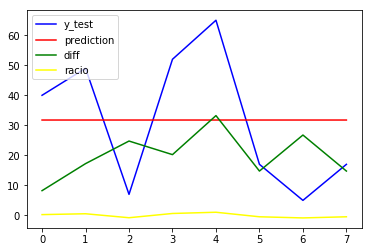

In [167]:
if __name__ == '__main__':
 #visualize_GOOGL()
 LSTM_()
 
 